<a href="https://colab.research.google.com/github/MANicholson/Figures-Modelling-and-Simulation-of-a-CMOS-Synapse-Implementing-Two-phase-Plasticity/blob/main/Figure_11_(a)_and_(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports


In [ ]:
!pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
import jax
import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
# import snntorch as snn
# import torch
# from snntorch import spikegen
import pandas as pd

# Base code for neural network

In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np

class many_synapse(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    reset_voltage: float
    V_rev: float
    V_spike_threshold: float
    tau_m: float
    R_m: float
    refractory_period: float
    h_0: float = 0.0

    def __call__(self, t_spike_pre_array, I_stim):
        num_input_neurons = t_spike_pre_array.shape[0]

        # Initial states
        i_ca = jnp.zeros((num_input_neurons, 1)) + self.ica_0
        v_h = jnp.zeros((num_input_neurons, 1)) + self.v_h0
        z_ji = jnp.zeros((num_input_neurons, 1)) + self.z_0
        w_ji = jnp.zeros((num_input_neurons, 1)) + self.beta * self.v_h0 + self.beta * self.v_h0 * self.z_0
        V_i = jnp.zeros((1,)) + self.V_rev
        p_i = jnp.zeros((num_input_neurons, 1))
        t_spike_post = 0.0  # Initialize t_spike_post to 0
        refractory_timer = jnp.zeros((1,))

        # Lists to store the results
        V_i_list = []
        t_spike_post_list = []

        def step(carry, input_):
            t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i, refractory_timer = carry
            t_spike_pre, I_stim = input_

            # Code for the neurons in the second layer:..............................

            in_refractory = jnp.squeeze(refractory_timer > 0)
            V_i = jax.lax.cond(in_refractory, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i, operand=None)

            inhibition_condition = jnp.squeeze(jnp.sum(I_stim) < 0)
            #V_i = jax.lax.cond(in_refractory, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i, operand=None)

            reversal_term = (1 / self.tau_m) * (-V_i + self.V_rev)
            pre_spike_contribution = (1 / self.tau_m) * jnp.sum(t_spike_pre * w_ji)
            current_term = (1 / self.tau_m) * jnp.sum((self.R_m * I_stim))

            spike_condition = jnp.squeeze(V_i > self.V_spike_threshold)

            V_i_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution, operand=None)
            #For inhibition
            V_i_new = jax.lax.cond(inhibition_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution, operand=None)

            # Update t_spike_post based on spike condition
            t_spike_post_new = jax.lax.cond(spike_condition, lambda _: 1.0, lambda _: 0.0, operand=None)
            t_spike_post_list.append(t_spike_post_new)

            refractory_timer_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.refractory_period]), lambda _: jax.numpy.maximum(refractory_timer - self.dt, 0), operand=None)

            # Calcium part ---------------------------------------------------------
            dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
            ica_pre_increase = t_spike_pre * self.delta_capre # <----------------------------------------------------------- TOOK AWAY JNP.SUM()
            ica_post_increase = t_spike_post_new * self.delta_capost
            i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase.T + ica_post_increase

            # print('t_spike_pre shape:', t_spike_pre.shape)

            # Early-phase part -----------------------------------------------------
            recovery_condition = jnp.squeeze(v_h > self.v_H0)
            potentiation_condition = jnp.squeeze(i_ca_new > self.I_THPOT)
            depression_condition = jnp.squeeze(i_ca_new > self.I_THDEP)

            # i_recovery = jax.lax.cond(recovery_condition, lambda _: - self.i_hrn, lambda _: self.i_hrp, operand=None)
            i_recovery = jnp.array([jnp.where(recovery_condition, - self.i_hrn, self.i_hrp)])

            # i_potentiation = jax.lax.cond(potentiation_condition, lambda _: self.I_TAILP, lambda _: self.I_TAILP_low, operand=None)
            i_potentiation = jnp.array([jnp.where(potentiation_condition, self.I_TAILP, self.I_TAILP_low)])

            # i_depression = jax.lax.cond(depression_condition, lambda _: - self.I_TAILD, lambda _: self.I_TAILD_low, operand=None)   ------------------------ 0.003, 0.0012, 62, 39.5
            i_depression = jnp.array([jnp.where(depression_condition, - self.I_TAILD, self.I_TAILD_low)])

            v_h_new = v_h + (1 / self.C) * (i_recovery.T + i_potentiation.T + i_depression.T) * self.dt

            # Ensure v_h_new is not less than 0
            v_h_new = jnp.maximum(v_h_new, 0)

            # Late-phase part ------------------------------------------------------
            epsilon_hi = jnp.abs(v_h_new - self.v_h0)
            condition = jnp.array([jnp.squeeze(epsilon_hi > self.theta_pro_circuit)])
            #p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)
            p_i = jnp.where(condition.T, self.alpha, p_i)
            pot_term = p_i * (self.z_max - z_ji) * ((v_h_new - self.v_h0 - self.theta_tag_c) > 0)
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h_new - self.theta_tag_c) > 0)
            dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)
            z_ji_new = z_ji + dz_dt * self.dt

            # Ensure z_ji_new is not less than 0
            z_ji_new = jnp.maximum(z_ji_new, 0)

            # Total synaptic weight ------------------------------------------------
            w_ji_new =  v_h_new +  z_ji_new * 18

            V_i_list.append(V_i_new)

            carry = (t_spike_post_new, i_ca_new, v_h_new, z_ji_new, p_i, w_ji_new, V_i_new, refractory_timer_new)
            return carry, (i_ca_new, v_h_new, z_ji_new, w_ji_new, V_i_new, t_spike_post_new)

        carry = (t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i, refractory_timer)
        _, (i_ca, v_h, z_ji, w_ji, V_i, t_spike_post) = jax.lax.scan(step, carry, (t_spike_pre_array.T, I_stim.T))

        time_array = jnp.arange(len((i_ca.T)[0][0])) * self.dt

        return i_ca.T, v_h.T, z_ji.T, w_ji.T, jnp.concatenate(V_i), t_spike_post, time_array


## Differential constants

In [ ]:
# Constants

# tc_delay = 0.0188  # Delay of postsynaptic calcium influx after presynaptic spike [s]
c_pre = 0.6  # Presynaptic calcium contribution [in vivo adjusted]
c_post = 0.1655  # Postsynaptic calcium contribution [in vivo adjusted]
tau_c = 0.0488  # Calcium time constant [s]
tau_h = 688.4 # ALTERED FROM 688.4  # Early-phase time constant [s]
tau_p = 60*60  # Protein time constant [s]
tau_z = 60*60  # Late-phase time constant [s]
# nu_th = 40  # Firing rate threshold for LTP induction [Hz]
gamma_p = 1645.6 # ALTERED FROM 1645.6  # Potentiation rate
gamma_d = 313.1 # ALTERED FROM 313.1  # Depression rate
theta_p = 0.003 # ALTERED FROM 3  # Calcium threshold for potentiation
theta_d = 0.002 # ALTERED FROM 1.2  # Calcium threshold for depression
# sigma_pl = 2.90436 * 10**(-3)  # Standard deviation for plasticity fluctuations [V]
alpha = 1.0  # Protein synthesis rate
theta_pro = 0.003 #2.10037  * 10**(-3)  # Protein synthesis threshold [V]
theta_tag = 0.840149  * 10**(-3)  # Tagging threshold [V]
h_0 = 4.20075  * 10**(-3) # Median initial excitatory→excitatory coupling strength [V]
h_init = h_0
z_0 = 0.0
# Combining Jorge's thesis and Jannik's paper

h_max = 10 * 10**(-3) # The maximum value of the early-phase variable [V]
z_max = 1 # The minimum value of the late-phase variable
z_min = - 0.5 # The maximum value of the late-phase variable

beta = 4.6675*10**(-3)

## Circuit constants

In [ ]:
# Calcium:
I_INDC = 25 * 10**(-12)
i_pre = 800 * 10**(-12)
i_post = 200 * 10**(-12) # CHANGED FROM: 200 * 10**(-12)
tau_DPI = 0.00488 # 4.88 * 10**(-3) <--- This works for a dt of 0.001
I_TH = 10 * 10**(-12)
I_TAU = 20 * 10**(-12)
ica_0 = 17 * 10**(-12)
delta_capre = 60 * 10**(-12) # CHanged from 60e-12
delta_capost = 15 * 10**(-12) # CHANGED FROM: 15 * 10**(-12)


# Early-phase:
tau_h_c = 68.84 # [s]
C = 1.2215 * 10**(-12)
v_H0 = 0.9 # [V] V_H0 = 1/2 * V_DD (page 30 Jorge)
I_THPOT = 62 * 10**(-12) # CHANGED FROM: 62 * 10**(-12), 75 works
I_THDEP = 39.5* 10**(-12) # CHANGED FROM: 39.5 * 10**(-12), 50 works
I_TAILP = 50 * 10**(-12)
I_TAILP_low = 1.2 * 10**(-15) #<----------------------------------------
I_TAILD = 10 * 10**(-12) # CHANGED FROM 10 * 10**(-12)
I_TAILD_low = 1.2 * 10**(-15) #<----------------------------------------
i_hrp = 2.5 * 10**(-15)
i_hrn = 80 * 10**(-15)
v_h0 = 900 * 10**(-3) # [V]
V_DD = 1.8 # [V] page 26 Jorge's thesis
z_0 = 0.00
# Late phase:
theta_tag_c = 0.0151226
theta_pro_circuit = 0.0
tau_z_c = 360
tau_p_c = 360


beta = 4.6675*10**(-3) # The constant needed to convvert the early-phase voltage given by Jorge's circuit to voltages comparable with Jannik's paper (and the late phase weight).

# Training the neural network

In [ ]:
tau_m = 0.01
V_rev = -0.065 #
R_m = 10e6
reset_voltage = -0.07
V_spike_threshold = 70
refractory_period = 0.0001
dt = 0.001

In [ ]:
manySynapse = many_synapse(
    tau_DPI, dt, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta, reset_voltage, V_rev, V_spike_threshold, tau_m, R_m, refractory_period
)

results = []

## Creating arrays with the final weights and plotting synaptic weights

In [ ]:
input_spikes = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# input_spikes = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]#, 0, 1, 0, 1, 0, 1, 0, 1, 0]#, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_spikes.extend([0]*100000)
INPUT_SPIKES = jnp.array([input_spikes])

stim = jnp.zeros_like(INPUT_SPIKES)

In [ ]:
calc, earl, late, tota, potent, postspikes, timeee = (manySynapse(INPUT_SPIKES, stim))

In [ ]:
# Data for Figure 11 (b), extracted from [12]
x3 = jnp.array([0.16447295890671368, 0.28195415601745294, 0.9868413386818926, 2.161653309789291, 3.8063900693396486, 7.800750771104803, 19.783832876400265, 25.65789273193726, 28.594922659705755, 32.58928336147091, 36.46616286612533, 39.87311758233678, 43.16259110143749, 47.86183898586708, 99.90600930592485, 49.3890945483067])
y3 = jnp.array([90.35928138521098, 181.26836794582988, 179.70096990168122, 180.0928194127184, 182.05206696790415, 183.61946501205276, 182.4439164789413, 177.34987283545834, 174.21507674716113, 171.08028065886396, 169.1210331036782, 167.94548457056675, 164.81068848226954, 159.32479532774943, 158.14924679463797, 158.14924679463797])
x2 = jnp.array([0.39943535312819384, 8.153194362437024, 20.606201256175446, 40.57800476500121, 100.02349050303557])
y2 = jnp.array([89.57558236313668, 112.69470351432854, 136.98937319863188, 158.54109630567515, 158.14924679463797])

x1 = jnp.array([0.16447295890671368, 0.16447295890671368, 0.8693601415711525, 20.488720059064708, 28.359960265484276, 36.23120047190385, 42.69266631299453, 45.277252649430814, 48.096801380088564, 50.91635011074632, 100.02349050303557])
y1 = jnp.array([90.35928138521098, 180.8765184347927, 178.13357185753264, 136.59752368759473, 120.1398442240344, 106.81696084877129, 97.80442209491683, 94.27777649558247, 91.92667942935957, 90.35928138521098, 89.96743187417381])


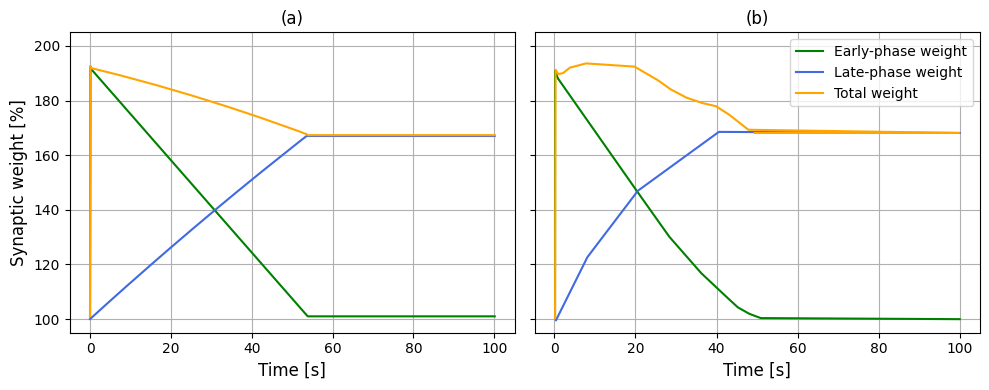

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))


# plt.fig_size()
# 20*(late[0][0]/13.35)/late[0][0][0] + 0.95
axes[0].set_title('(a)')
axes[0].plot(timeee, earl[0][0]/(earl[0][0][0])*24 + 77, color = 'green')
axes[0].plot(timeee, 100+485*late[0][0], color = 'royalblue')
axes[0].plot(timeee, 77+24*tota[0][0]/(earl[0][0][0]), color = 'orange')
axes[0].set_ylim(95, 205)
axes[0].grid()
axes[0].set_xlabel('Time [s]', fontsize = 12)
axes[0].set_ylabel('Synaptic weight [%]', fontsize = 12)

axes[1].set_title('(b)')
axes[1].plot(x1, y1+10, color = 'green', label = 'Early-phase weight')
axes[1].plot(x2, y2+10, color = 'royalblue', label = 'Late-phase weight')
axes[1].plot(x3, y3+10, color = 'orange', label = 'Total weight')
axes[1].set_ylim(95, 205)
axes[1].legend(loc = 'upper right')
axes[1].set_yticklabels([])
axes[1].grid()
axes[1].set_xlabel('Time [s]', fontsize = 12)

plt.tight_layout()


